# Chebyshev methods for non-periodic functions

We learned that smooth periodic functions and their derivatives can be well approximated by trigonometric interpolants:
$$
f(x) \approx p(x) =  \sum_{k=-(n-1)/2}^{(n-1)/2} \tilde{c}_k{\rm e}^{{\rm i}kx}
$$
and there are fast algorithms for mapping function values to coeffients and vice versa and for differentiation.  We saw how Fourier approximation methods could be used to compute an approximate solution to a PDE.

Here we'll learn that smooth non-periodic functions and their derivatives can be accurately and stably approximated by expansions in orthogonal polynomials (OPs),
$$
f(x) \approx \sum_{k = 0}^{n}  c_k p_k(x).
$$
and there are  fast algorithms for computing with OPs.  We'll also learn how OPs can be used to approximate solutions to PDEs.

## The Runge phenomenon and its resolution via OPs

Suppose we want to approximate the function $f(x) = \frac{1}{1 + 25x^2}$ (known as the Runge function) on the interval $x \in[-1, 1]$.  We know that a trigonometric interpolant will not converge very fast to $f$.  Instead, we approximate $f$ by a polynomial interpolant that interpolates $f$ at $n+1$ equally spaced points on $[-1, 1]$.  One method to find the interpolating polynomial is to use the formula for the Lagrange interpolating polynomial.  Instead, here we use the following "quick and dirty" method, based on inverting the Vandermonde matrix. 

**Definition (Vandermonde)** The _Vandermonde matrix_ associated with $n+1$ distinct points $x_0,…,x_n ∈ ℝ$
is the matrix
$$
V := \begin{bmatrix} 1 & x_0 & ⋯ & x_0^{n} \\
                    ⋮ & ⋮ & ⋱ & ⋮ \\
                    1 & x_n & ⋯ & x_n^{n}
                    \end{bmatrix}
$$

 We recall the definition of a polynomial interpolant / interpolating polynomial / interpolatory polynomial:

**Definition (polynomial interpolant)** Given $n+1$ distinct points $x_0,…,x_n ∈ ℝ$ 
and $n+1$ _samples_ $f_0,…,f_n ∈ ℝ$, a degree $n$
_polynomial interpolant_ $p(x)$ satisfies
$$
p(x_j) = f_j, \qquad j = 0, \ldots, n
$$

**Proposition (interpolatory polynomial uniqueness)** 
The interpolatory polynomial is unique, and the Vandermonde matrix is invertible.

**Proof**
Suppose $p$ and $\tilde{p}$ are both interpolatory polynomials. Then $p(x) - \tilde{p}(x)$ vanishes at $n+1$ distinct points $x_j$. By the fundamental theorem of
algebra it must be zero, i.e., $p = \tilde{p}$.

For the second part, if $V \mathbf{c} = \mathbf{0}$ for $\mathbf{c} ∈ \mathbb{R}^{n+1}$ then for $q(x) = c_0 + c_1 x + ⋯ + c_{n} x^{n}$ we have
$$
q(x_j) = \mathbf{e}_j^⊤ V \mathbf{c} = 0, \qquad j = 1, \ldots, n+1,
$$
where $\mathbf{e}_j \in \mathbb{R}^{n+1}$ are the canonical basis unit vectors, 
$$
\mathbf{e}_1 = \begin{bmatrix}
1 \\
0 \\
\vdots \\
\vdots \\
0
\end{bmatrix}, \quad  \mathbf{e}_2 = \begin{bmatrix}
0 \\
1 \\
0 \\
\vdots \\
0
\end{bmatrix}, \ldots
$$
hence $q$ vanishes at $n+1$ distinct points and is therefore 0, i.e., $\mathbf{c} = \mathbf{0}$.
$\blacksquare$

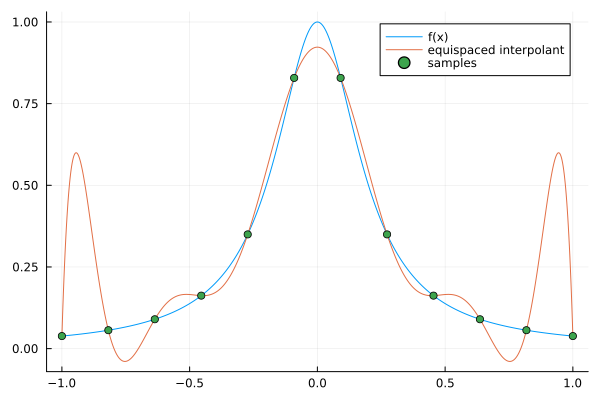

In [51]:
using Plots, LinearAlgebra, ApproxFun, FFTW

f = x -> 1/(25x^2 + 1)

# Construct an interpolant through n + 1 equally spaced points on [-1, 1]
n = 11
x = range(-1,1;length=n+1)  # n+1 equispaced nodes  
xx = range(-1,1;length=1001)  # plotting grid
V = x .^ (0:n)' # Vandermonde matrix
c = V \ f.(x) # coefficients of interpolatory polynomial
p = x -> dot(c, x .^ (0:n))
plot(xx,f.(xx);label="f(x)")
plot!(xx,p.(xx);label="equispaced interpolant")
scatter!(x,p.(x);label="samples")

The oscillations at the ends of the interval become larger as we increase $n$:

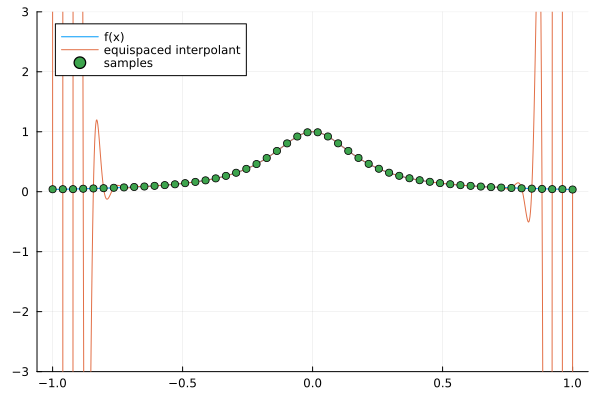

In [52]:
n = 51
x = range(-1,1;length=n+1)  # n+1 equispaced nodes  
V = x .^ (0:n)' # Vandermonde matrix
c = V \ f.(x) # coefficients of interpolatory polynomial
p = x -> dot(c, x .^ (0:n))
plot(xx,f.(xx);label="f(x)",ylims=(-3,3))
plot!(xx,p.(xx);label="equispaced interpolant")
scatter!(x,p.(x);label="samples")

These oscillations of the interpolant through equally spaced nodes is known as the *Runge phenomenon* (not to be confused with the Gibbs phenomenon). Equally spaced interpolation nodes is clearly not a good choice for high-degree polynomial interpolation.  Maybe the oscillations at the endpoints can be suppressed if we choose nodes that are clustered at the ends of the interval?

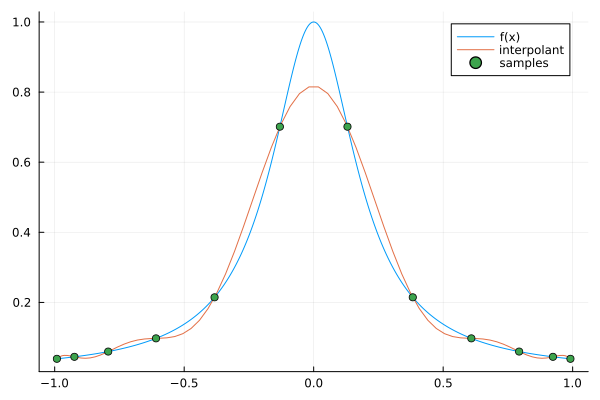

In [53]:
# Construct an interpolant using ApproxFun
n = 11
S = Chebyshev()
p = Fun(f,S,n+1) # an interpolant through the unevenly spaced nodes x
x = points(S,n+1)  # n+1 unevenly spaced points 
plot(xx,f.(xx);label="f(x)")
plot!(p;label="interpolant")
scatter!(xn,p.(xn);label="samples")

In the above figure, we interpolated $f(x)$ at the roots of an orthogonal polynomial (OP), which we'll learn about later.  The interpolants at the roots of the OP converge exponentially fast to $f$ on $[-1, 1]$ as $n$ increases.

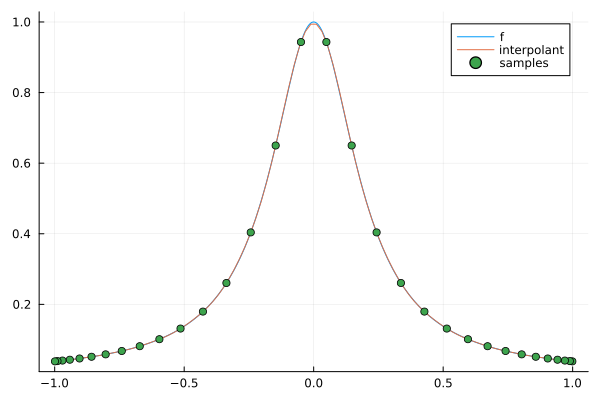

In [54]:
n = 31
S = Chebyshev()
p = Fun(f,S,n+1) 
x = points(S,n+1) 
plot(xx,f.(xx);label="f")
plot!(p;label="interpolant")
scatter!(x,p.(x);label="samples")

**Remark (advanced)**  A deep and quantitative understanding of the reasons why equispaced interpolation failed for the above function and why interpolants through clustered points converged fast is a beautiful and advanced topic that requires tools from complex analysis and potential theory (See *Approximation Theory and Approximation Practice* by L.N. Trefethen).

## An introduction to Chebyshev polynomials

**Definition (Chebyshev polynomials of the first kind)**
$$
T_n(x) = \cos n\, {\rm acos} x, \qquad x \in [-1, 1],
$$
or in other words,
$$
T_n(\cos \theta) = \cos n \theta, \qquad \theta \in [0, \pi].
$$

**Proposition (Chebyshev three-term recurrence)**  The Chebyshev polynomials satisfy the following three-term recurrence:
$$
\begin{align*}
xT_{n} = \frac{T_{n-1}(x) + T_{n+1}(x)}{2}, \qquad n \geq 1.
\end{align*}
$$

**Proof**

It follows immediately from the definition that $T_0(x) = 1$, $T_{1}(x) = x$ and for $n \geq 1$
$$
x T_n(x) = \cos θ \cos n θ = {\cos(n-1)θ + \cos(n+1)θ \over 2} = {T_{n-1}(x) + T_{n+1}(x) \over 2}
$$
In other words $T_{n+1}(x) = 2x T_n(x) - T_{n-1}(x)$ for $n \geq 1$.

$\blacksquare$

**Corollary** $T_n(x)$ is a polynomial of degree precisely $n$.

Here are a few Chebyshev polynomials

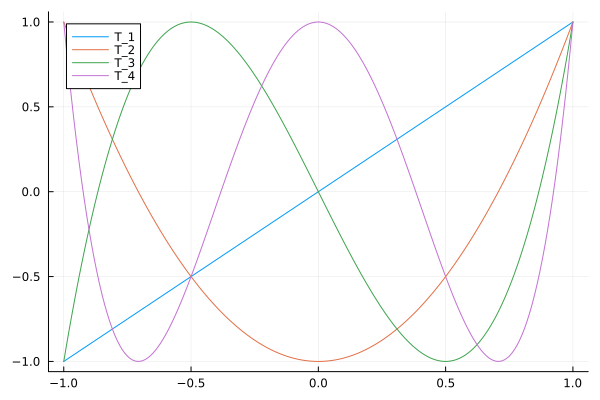

In [55]:
xx = -1:0.01:1
p = plot()
for k = 1:4
    plot!(xx,Fun(Chebyshev(),[fill(0,k);1]).(xx);label="T_$k")
end
p

In the example above, we resolved the Runge phenomenon by interpolating the function at the roots of $T_n(x)$, which are at
$$
    x_j = \cos\left(\frac{(2j+1)\pi}{2n}\right), \qquad j = 0, \ldots, n-1, 
$$
since $T_n(x_j) = \cos n\,\mathrm{acos} x_j = \cos\left(\frac{(2j+1)\pi}{2}\right) = 0$.  Later on, we shall be interested in the points
$$
x_j = \cos\left(\frac{j\pi}{n}\right), \qquad j = 0, \ldots, n, 
$$
which are the extrema (maxima and minima) of $T_{n+2}(x)$.  Notice that the roots of $T_n$ are in $(-1, 1)$, whereas the extrema of $T_{n+2}$ are in $[-1, 1]$.

## The derivatives of interpolants in Chebyshev points can be computed with the FFT

Suppose a function $f(x)$ has a convergent Chebyshev series on $[-1, 1]$, i.e.,
$$
f(x) = \sum_{k=0}^{\infty} b_k T_k(x).
$$
Let's call the function that results from the change of variable $x = \cos \theta$, $g(\theta)$, i.e.,
$$
g(\theta) = f(\cos \theta).
$$
Notice that $g$ is an even, $2\pi$-periodic function of $\theta$.  We have that
$$
\begin{eqnarray*}
f(x) &=& \sum_{k=0}^{\infty} b_k T_k(x) \\
  &=& \sum_{k=0}^{\infty} b_k\cos k\theta   \qquad (x = \cos \theta)  \\
  & = & g(\theta) \\
  &=& \sum_{k=0}^{\infty} b_k\left(\frac{{\rm e}^{{\rm i}k\theta} + {\rm e}^{-{\rm i}k\theta}}{2}   \right) \\
  &=& \sum_{k=-\infty}^{\infty} c_k {\rm e}^{{\rm i}k\theta}  \qquad (c_0 = b_0, c_{k} = c_{-k} = b_k/2, k\geq 1).
\end{eqnarray*}
$$
That is, a Chebyshev series is a Fourier series in disguise!

When we studied Fourier methods for periodic functions, we learnt that the trigonometric interpolant $q_n(\theta)$, where

$$
\begin{eqnarray*}
g(\theta) = f(\cos\theta) = f(x) \approx p_n(x) = \sum_{k=0}^{n} \tilde{b}_kT_k(x) = \sum_{k=-n}^{n} \tilde{c}_k {\rm e}^{{\rm i}k\theta} := q_n(\theta)
\end{eqnarray*}
$$

interpolates the periodic function $g(\theta)$ at the points $\theta_j = 2\pi j/(2n+1)$ with $j = 0, \ldots, 2n$, where the approximate Fourier coefficients $\tilde{c}_k$ can be computed via the FFT given the function values $g(\theta_j)$.  This means that $p_n(x_j) = f(x_j)$ for 
$$
    x_j = \cos\theta_j = \cos\left( \frac{2\pi j}{2n + 1}  \right), \qquad j = 0, \ldots, 2n 
$$

and we have that

$$
\tilde{c}_0 = \tilde{b}_0,\qquad  \tilde{c}_{k} = \tilde{c}_{-k} = \tilde{b}_k/2,\qquad k\geq 1,
$$

where
$$
\tilde{c}_k = \frac{1}{2n+1}\sum_{j = 0}^{2n} g(\theta_j) {\rm e}^{-{\rm i}k\theta_j}, \qquad k = -n, \ldots, n.
$$

We refer to $p_n(x) = \sum_{k=0}^{n} \tilde{b}_kT_k(x)$ as the Chebyshev interpolant of $f(x)$ and the $\tilde{b}_k$ are the approximate Chebyshev coefficients of the the function $f$ we are approximating.

Here are the coefficients $\tilde{b}_k$ of the Chebyshev interpolant of the Runge function, which we can obtain using ApproxFun.jl or Chebfun in Matlab:

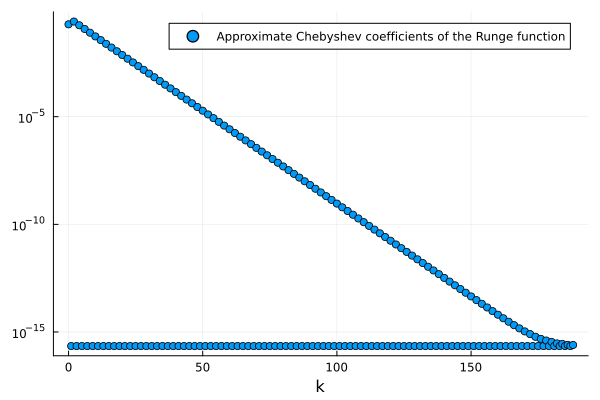

In [75]:
f = x -> 1/(1 + 25x^2) # Runge function
fcheb = Fun(f,Chebyshev()) # high-accuracy Chebyshev interpolant
bt = fcheb.coefficients # approximate Chebyshev coefficients
scatter(0:length(fc)-1,abs.(fc).+eps();
    xlabel="k", yscale=:log10,label="Approximate Chebyshev coefficients of the Runge function")

The $\tilde{b}_k$ coefficients decay exponentially fast with $k$ because the Runge function is analytic on $[-1, 1]$.   Let's check that the approximate Fourier coefficients and Chebyshev coefficients are related as stated above:

In [76]:
g = θ -> f(cos(θ)) 
n = length(fc)-1
θ = range(0,2π;length= 2n+2)[1:end-1] 
ct = fft(g.(θ))/(2n+1) # compute approximate Fourier coefficients
@show ct[1] ≈ bt[1];
@show 2ct[2:n+1] ≈ bt[2:n+1]
norm(2ct[2:n+1] - bt[2:n+1],Inf)

ct[1] ≈ bt[1] = true
2 * ct[2:n + 1] ≈ bt[2:n + 1] = true


9.898839542956632e-17

Hence, we can also approximate derivatives of $f$ by differentiating $q_n(\theta)$ in Fourier coefficient space via the FFT, which is very efficient, as we learnt when we studied Fourier methods for periodic functions. The first derivatives are related as follows:

$$
f'(x) \approx \frac{{\rm d}}{{\rm d}x}p_n(x) = \frac{{\rm d}}{{\rm d}x}q_n(\theta) = q_n'(\theta)\frac{{\rm d} \theta}{\mathrm{d}x} = -\frac{q_n'(\theta)}{\sin \theta}
$$

In [90]:
df = x -> -50x/(1 + 25x^2)^2 # f', the derivative of the Runge function
# differentiate qₙ in coeffcient space and map back to function values space
dqn = (2n + 1)*ifft( im*ifftshift(-n:n).* ct) 
dpn = -dqn ./sin.(θ)  # pₙ', derivative of pₙ
x = cos.(θ)
# the error of the approximation f' ≈ pₙ'
norm(df.(x[2:end]) - dpn[2:end],Inf)

8.453005772678412e-13

 Note that $p_n'(x) = -q_n'(\theta)/\sin \theta$ is not well-defined for $\theta = 0, \pi$ (i.e., at $x = \cos\theta =
 \pm 1$).  For these cases we use l'Hopital's rule.

We typically prefer to approximate a function (or solution to a differential equation) at the *Chebyshev points*, 
$$
x_j = \cos\left(\frac{j\pi}{n}\right), \qquad j = 0, \ldots, n,
$$
because these include the end points of the interval $[-1, 1]$ where we typically impose boundary conditions. Here is a function that that takes as input the function values $f(x_j)$, $j = 0, \ldots, n$ at the Chebyshev points and it returns $p_n'(x_j)$, $j = 0, \ldots, n$ via the FFT (the derivate of the Chebyshev interpolant at the Chebyshev points, which approximate $f'(x_j)$). The formulae for performing differentiation at the Chebyshev points via the FFT are slightly different from the formulae discussed above, where we considered a different set of points, namely $ x_j = \cos\theta_j = \cos\left( \frac{2\pi j}{2n + 1}  \right), j = 0, \ldots, 2n $

In [157]:
function chebfft(f)
    n = length(f)-1
    x = cos.((0:n)*π/n) # Chebyshev points
    ii = 0:n-1
    q = [f; f[n:-1:2]]      # transform x -> θ    
    # differentiate the interpolant qₙ in coefficient space and map back to function values
    cq = real.(fft(q))
    dq = real.(ifft(im*[ii; 0; 1-n:-1] .*cq))
    df = zeros(n+1,1)
    # Compute approximations to f' at the interior points
    df[2:n] = -dq[2:n] ./sqrt.(1 .- x[2:n].^2)    # transform θ -> x   
    # At the boundary points
    df[1] = sum(ii.^2 .*cq[1:n])/n + .5*n*cq[n+1]     
    df[n+1] = sum((-1) .^(ii .+1) .* ii.^2 .*cq[1:n])/n +
              .5*(-1)^(n+1)*n*cq[n+1]
    df
end

chebfft (generic function with 1 method)

## Differentiation matrices for Chebyshev interpolants

When we studied Fourier methods for periodic functions, we learnt about two representations of the trigonometric interpolant.  Here we do the same for Chebeshev polynomial interpolants. We have already seen one representation as an expansion in Chebyshev polynomials
$$
p_n(x) = \sum_{k = 0}^{n}\tilde{b}_kT_k(x),
$$
which allowed us to leverage Fourier series to compute $\tilde{b}_k$ and derivatives of $p_n(x)$ via the FFT.  We now build differentiation matrices to compute derivatives of $p_n(x)$ by using its representation as a Lagrange interpolating polynomial.

Recall from the formula for the Lagrange interpolating polynomial that
$$
p_n(x) = \sum_{k = 0}^{n}\ell_k(x)f(x_k), \qquad \ell_k(x) = \prod_{\substack{j=0\\ j \neq k}}^{k}\frac{x-x_j}{x_k-x_j}
$$
here we let $x_k$ be the Chebyshev points 
$$
x_k = \cos\left(\frac{\pi k}{n} \right), \qquad k = 0, \ldots, n.
$$

We can represent differentiation of the Chebyshev interpolant via an $(n+1) \times (n+1)$ differentiation matrix $D_n$: since
$$
p_n'(x) = \sum_{k = 0}^{n}\ell_k'(x)f(x_k),
$$
we have
$$
\begin{bmatrix}
p_n'(x_0) \\
\vdots \\
p_n'(x_n)
\end{bmatrix} = 
\begin{bmatrix}
\ell_0'(x_0) & \cdots & \ell_n'(x_0) \\
\vdots & \vdots  & \vdots \\
\ell_0'(x_n) & \cdots & \ell_n'(x_n)
\end{bmatrix}
\begin{bmatrix}
f(x_0) \\
\vdots \\
f(x_n)
\end{bmatrix}
$$
or in vector form,
$$
\mathbf{p}' = D_n \mathbf{f}.
$$

Here is a function that builds the differentiation matrix $D_n$:

In [190]:
function cheb(n)

    x = cos.(π*(0:n)/n)
    c = [2; ones(n-1,1); 2].*(-1).^(0:n)
    X = repeat(x,1,n+1)
    dX = X-X'
    D = (c*(1 ./c)')./( dX + I ) # off-diagonal entries
    D = D - diagm(vec(sum(D';dims=1)))# diagonal entries
    
    D, x

end

cheb (generic function with 1 method)

To summarise, we have two equivalent methods for computing the derivate of the Chebyshev interpolant at the $n+1$ Chebyshev points.  The FFT method has $\mathcal{O}(n\log n)$ complexity while  applying a differentiation matrix to a vector requires $\mathcal{O}(n^2)$ operations because $D_n$ is a dense matrix.

Let's check that the two methods give the same output:

In [207]:
n = 50
D,x = cheb(n)
D*f.(x) ≈ chebfft(f.(x))

true

## A PDE example: the wave equation

Consider the following $(1+1)$-dimensional wave equation PDE initial/boundary value problem 
$$
u_{tt} = u_{xx}, \qquad t > 0, \qquad -1 < x < 1, \qquad u(\pm 1, t) = 0,
$$
subject to the initial data
$$
u(x,0) = f(x), \qquad u_t(x,0) = g(x), \qquad x \in [-1, 1],
$$
where we assume that not both of $f$ and $g$ are identically zero (because then the trivial solution $u(x,t) = 0$ solves the problem).  We are going to approximate the solution to this problem by approximating $u_{tt}$ with finite differences and $u_{xx}$ with differentiation of a Chebyshev interpolant in $x$. First, we derive the exact solution to this problem using the method of separation of variables. 

### The method of separation of variables

We attempt to find a solution of the form
$$
u(x,t) = X(x)T(t).
$$ 
From the zero boundary conditions, we conclude that
$$
u(-1,t) = X(-1)T(t) = 0 = T(t)X(1) = u(1,t) \quad \Rightarrow \quad X(-1) = 0 = X(1).
$$
Substituting $u = XT$  into the PDE, we find that
$$
\frac{T''(t)}{T(t)} = \frac{X''(x)}{X(x)}. 
$$
This can hold only if 
$$
\frac{T''(t)}{T(t)} = \frac{X''(x)}{X(x)} = \lambda \in \mathbb{R}.
$$
We need to consider three cases
1. $\lambda > 0$
2. $\lambda = 0$
3. $\lambda < 0$

Cases (1) and (2) are left as an exercise. 

For case (3), we set $\lambda = - \kappa^2$ with $\kappa \in \mathbb{R}\setminus \{0\}$ then for $X$ we have the ODE boundary-value (or eigenvalue) problem
$$
X'' = -\kappa^2 X, \qquad X(-1) = 0 = X(1)
$$


The general solution to the ODE $X''+\kappa^2 X = 0$ is $X = c_1 \sin\kappa x + c_2\cos\kappa x$, for arbitrary constants $c_1$, $c_2$ ($\sin\kappa x$ and $\cos\kappa x$ are eigenfunctions of the differential operator $\frac{{\rm d}^2}{{\rm d}x^2}$). To satisfy the boundary conditions $X(-1) = 0 = X(1)$, we require
$$
-c_1 \sin\kappa + c_2\cos\kappa = 0 = c_1 \sin\kappa  + c_2\cos\kappa .
$$
Since $\kappa \neq 0$ and $\sin \kappa$ and $\cos \kappa$ are linearly independent functions, these equations hold only if $c_1 = c_2 = 0$, which implies that $X=0$ which would give the inadmissable solution $u = 0$.  Instead, we attempt to find solutions of the form (i) $X = c_1 \sin\kappa x$  and (ii) $X = c_1 \cos\kappa x$.  For case (i), we require
$$
    \kappa = \kappa_n = \pi n
$$
in order to satisfy $X(-1) = 0 = X(1)$ and for case (ii),
$$
\kappa = \kappa_n = (2n + 1)\frac{\pi}{2}
$$
where $n \in \mathbb{Z}$.  For case (i), $T$ has the solution
$$
T(t) = c_1 \sin\kappa_n t + c_2\cos\kappa_n t   \qquad (1)
$$
with $\kappa_n = \pi n$ and in case (ii), $T$ has the solution (1) with $\kappa_n = (2n + 1)\frac{\pi}{2}$.  As before, $c_1$ and $c_2$ are arbitrary constants.  We have therefore constructed two families of solutions to the wave equation:
$$
u = \left( c_1 \sin\kappa_n t + c_2\cos\kappa_n t \right)\sin \kappa_n x, \qquad \kappa_n = \pi n
$$
and
$$
u = \left( b_1 \sin\kappa_n t + b_2\cos\kappa_n t \right)\cos \kappa_n x, \qquad \kappa_n =(2n + 1)\frac{\pi}{2}.
$$
Since the wave equation is linear, any scalar multiples and linear combinations of the solutions above are also solutions to the PDE initial/boundary-value problem. 



Therfore the following series is a formal solution to the PDE,
$$
u(x,t) = \sum_{n = 1}^{\infty} \left(\alpha_n\sin\pi n t + \beta_n\cos\pi n t  \right)\sin\pi n x +  \sum_{n = 0}^{\infty} \left(\gamma_n\sin \kappa_n t + \delta_n\cos \kappa_n t  \right)\cos\kappa_n x,
$$
where $\kappa_n =(2n + 1)\frac{\pi}{2}$ and  $\alpha_n, \beta_n, \gamma_n, \delta_n$ are arbitrary constants whose values we shall determine by using the initial data:

$$
u(x,0) = \sum_{n = 1}^{\infty} \beta_n  \sin\pi n x +  \sum_{n = 0}^{\infty} \delta_n \cos\kappa_n x = f(x)
$$
$$
u_t(x,0) = \sum_{n = 1}^{\infty} \pi n\alpha_n  \sin\pi n x +  \sum_{n = 0}^{\infty}\kappa_n \gamma_n \cos\kappa_n x = g(x)
$$

Using the fact that 
$$
\int_{-1}^{1} \sin \pi n x \sin \pi m x\, {\rm d}x = \delta_{n,m} = \begin{cases}
1 & \text{if } n = m \\
0 & \text{otherwise}
\end{cases}
$$
$$
\int_{-1}^{1} \sin \pi n x \cos \kappa_m x\, {\rm d}x = 0, \qquad n, m \geq 0 
$$
and
$$
\int_{-1}^{1} \cos \kappa_n x \cos \kappa_m x\, {\rm d}x = \delta_{n,m} 
$$
it follows that
$$
\beta_m = \int_{-1}^{1} f(x) \sin m\pi x \,{\rm d}x, \quad m\geq 1, \qquad \delta_m = \int_{-1}^{1} f(x) \cos \kappa_m x \,{\rm d}x,\quad m \geq 0
$$
and
$$
\alpha_m = \frac{1}{\pi n}\int_{-1}^{1} g(x) \sin m\pi x \,{\rm d}x, \quad m\geq 1, \qquad \gamma_m = \frac{1}{\kappa_n}\int_{-1}^{1} g(x) \cos \kappa_m x \,{\rm d}x,\quad m \geq 0.
$$

We have derived the exact solution to the PDE intial/boundary value problem as the sum of two series.  To compute an approximation to the solution, we could use the FFT to compute approximate coefficients  $\tilde{\alpha}_n$, $\tilde{\beta}_n$, $\tilde{\gamma}_n$, $\tilde{\delta}_n$ and then set
$$
u(x,t) \approx \sum_{n = 1}^{N} \left(\tilde{\alpha}_n\sin\pi n t + \tilde{\beta}_n\cos\pi n t  \right)\sin\pi n x +  \sum_{n = 0}^{N} \left(\tilde{\gamma}_n\sin \kappa_n t + \tilde{\delta}_n\cos \kappa_n t  \right)\cos\kappa_n x.
$$
This method relies on knowing the exact solution to the problem, which may not be possible for a more complicated PDE.
Instead, we shall compute an approximate solution using a combination of finite differences and Chebyshev interpolants, which is a method which doesn't require knowing the exact solution.

**Remark** We derived an exact solution to the initial/boundary-value PDE problem above.  If we consider the "pure" initial-value problem (the Cauchy problem) for the wave equation on the whole real line, i.e., 
$$
u_{tt} = u_{xx}, \qquad t > 0, \qquad x \in \mathbb{R},
$$
note there are no boundary conditions, then it is easy to verify that 
$$
u(x,t) = F(x-t) + G(x+t)
$$
is a solution to the Cauchy problem, where $F$ and $G$ are unknown functions that can be determined from the initial data
$$
u(x,0) = f(x), \qquad u_t(x,0) = g(x).
$$
This solution can be derived using the method of characteristics. 


### Numerical solution

We consider the initial/boundary-value problem for the wave equation
$$
u_{tt} = u_{xx}, \qquad t > 0, \qquad -1 < x < 1, \qquad u(\pm 1, t) = 0.
$$


We discretise $x$ using the Chebyshev points,
$$
x_j =  \cos\left(  \frac{j\pi}{n_x}\right), \qquad j = 0, \ldots, n_x, 
$$
and we let $t \in [0, T]$ and set
$$
t_i = i\tau, \qquad \tau = \frac{T}{n_t}, \qquad i = 0, \ldots, n_t.
$$
We let $u^{i}_j$ denote the approximation to the exact solution $u$ at $x=x_j$ and $t = t_i$, i.e.,
$$
u^{i}_j \approx u(x_j, t_i),
$$
and we let $\mathbf{u}^{i}$ denote the vector of approximations at "time-level" $i$:
$$
\mathbf{u}^{i} = \begin{bmatrix}
u^{i}_0 \\
u^{i}_1 \\
\vdots \\
u^{i}_n
\end{bmatrix}.
$$


The second time-derivative is approximated with a central difference approximation:
$$
u_{tt}(x_j,t_i) \approx \frac{u(x_j,t_{i+1}) - 2u(x_j,t_{i}) + u(x_j,t_{i-1})}{\tau^2} \approx \frac{u^{i+1}_j - 2u^{i}_j + u^{i-1}_j}{\tau^2}, \qquad j = 0, \ldots, n_x
$$
or, in vector notation,
$$
u_{tt}(\mathbf{x},t_i) \approx \frac{\mathbf{u}^{i+1} - 2\mathbf{u}^{i} + \mathbf{u}^{i-1}}{\tau^2}.
$$
The spatial derivative is approximated by differentiation of a Chebyshev interpolant in $x$: 
$$
\begin{bmatrix}
u_x(x_0,t_i) \\
\vdots \\
u_x(x_n,t_i)
\end{bmatrix} \approx 
\begin{bmatrix}
\ell_0'(x_0) & \cdots & \ell_n'(x_0) \\
\vdots & \vdots  & \vdots \\
\ell_0'(x_n) & \cdots & \ell_n'(x_n)
\end{bmatrix}
\begin{bmatrix}
u(x_0,t_i) \\
\vdots \\
u(x_n,t_i) 
\end{bmatrix}
\approx
\begin{bmatrix}
\ell_0'(x_0) & \cdots & \ell_n'(x_0) \\
\vdots & \vdots  & \vdots \\
\ell_0'(x_n) & \cdots & \ell_n'(x_n)
\end{bmatrix}
\begin{bmatrix}
u_0^i \\
\vdots \\
u_n^i
\end{bmatrix}
$$
i.e.,
$$
u_{x}(\mathbf{x},t_i) \approx D_n\mathbf{u}^{i}
$$
and
$$
u_{xx}(\mathbf{x},t_i) \approx D_n\left(D_n\mathbf{u}^{i}\right) = D_n^2\mathbf{u}^{i}.
$$
Therefore we approximate the solution to the PDE as follows:
$$
\mathbf{u}^{i+1} = 2\mathbf{u}^{i} - \mathbf{u}^{i-1} + \tau^2 D_n^2\mathbf{u}^{i}, \qquad i = 0, \ldots, n_t-1.
$$

**Remark** Note that we don't need to include the approximations $u_0^{i}$ and $u_n^{i}$ since we know the solution values at $x = \pm 1$ from the zero boundary conditions $u(\pm 1, t) = 0$.  For now we ignore this fact since we shall discuss the imposition of boundary conditions later in this module.

**Remark** In practice, we don't compute $D_n^2\mathbf{u}^{i}$ by building the differentiation matrix $D_n$ and squaring it, since it costs $\mathcal{O}(n_x^3)$ operations, however computing $D_n(D_n\mathbf{u}^{i})$ has $\mathcal{O}(n_x^2)$ complexity. As we showed above, $D_n\mathbf{u}^{i}$ can be computed with the FFT with $\mathcal{O}(n_x\log n_x)$ complexity, so we compute $D_n^2\mathbf{u}^{i}$ by differentiating twice via the FFT, which thus also has $\mathcal{O}(n_x\log n_x)$ complexity.

We require two starting values to implement the numerical method.  We let
$$
u(x,0) = f(x) = {\rm e}^{-200x^2}.
$$
Rather than specifying $u_t(x,0)$, we impose the condition
$$
u(x,-\tau) = f(x - \tau) = {\rm e}^{-200(x-\tau)^2}.
$$
(Recall that $u(x,t) = F(x+t)$ is a solution to the Cauchy problem for the wave equation).  Hence, the numerical method is 
$$
\mathbf{u}^{0} = f(\mathbf{x}), \qquad \mathbf{u}^{-1} = f(\mathbf{x}-\tau), \qquad \mathbf{u}^{i+1} = 2\mathbf{u}^{i} - \mathbf{u}^{i-1} + \tau^2 D_n^2\mathbf{u}^{i}, \qquad i = 0, \ldots, n_t-1.
$$

See Matlab m-file

In [433]:
N = 80; x = cos.(π*(0:N)/N); dt = 8/N^2;
v = exp.(-200*x.^2);vold = exp.(-200*(x .- dt).^2)
tmax = 4; tplot = 0.02;
plotgap = Int64(round(tplot/dt)); dt = tplot/plotgap;
nplots = @show Int64(round(tmax/tplot))
plotdata = [transpose(v); zeros(nplots,N+1)]; tdata = [0.0];
for i = 1:nplots
    for n = 1:plotgap
        w = chebfft(chebfft(v)); w[1]=0; w[N+1] = 0;
        vnew = 2*v - vold + dt^2*w; vold = v; v = vnew;
    end
    plotdata[i+1,:] = v; tdata = [tdata;dt*i*plotgap]
end

Int64(round(tmax / tplot)) = 200


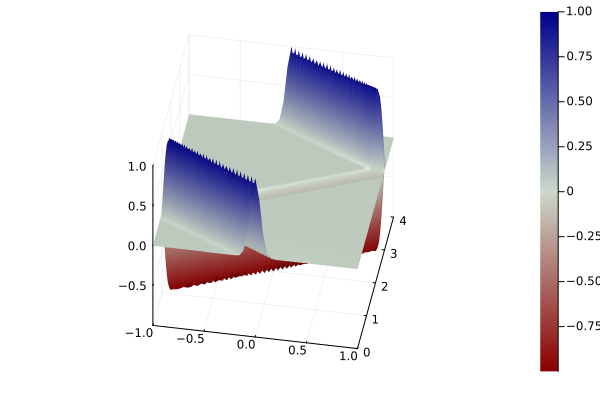

In [435]:
surface(x,tdata,plotdata,seriescolor=:redsblues, camera=(10,40))

## Rate of convergence of Chebyshev interpolants and its derivatives

Since Chebyshev interpolants of a generally non-periodic function $f(x)$ on $[-1, 1]$ are trigonometric interpolants of the periodic function $g(\theta) = f(\cos\theta)$, we can deduce the rate of convergence of Chebyshev interpolating polynomials from the rate of convergence of trigonometric interpolants of $g(\theta)$.

**Examples**
1. For $f(x) = \vert x \vert$, $x \in [-1, 1]$, it follows that $g(\theta) = \vert \cos\theta \vert$, $\theta \in [0, \pi]$.  To apply the results we stated for periodic functions, we need to consider $g$ on the interval $[0, 2\pi]$.  Since $g(\theta) \in C^{0}[0, 2\pi]$, $\| g^{(k)}\|_1 < \infty$ for $k = 0, 1, 2$ (verify) and $g^{(1)}(0), g^{(1)}(2\pi) < \infty$, it follows that
$$
\| q_n(\theta) - g(\theta) \|_{\infty} = \| p_n(x) - f(x) \|_{\infty} = \mathcal{O}\left( n^{-1} \right), \qquad n \to \infty.
$$
where $q_n(\theta)$ is the trigonometric interpolant of $g(\theta)$ and $p_n(x)$ is the Chebyshev interpolant of $f(x)$.
2. For $f(x) = \vert x \vert^3$ we want to know how fast does the derivative of the Chebyshev interpolant converge to $f'$.  following the same reasoning as in the previous example, since $g(\theta) \in C^{2}[0, 2\pi]$, $\| g^{(k)}\|_1 < \infty$ for $k = 0, \ldots, 4$ and $g^{(3)}(0), g^{(3)}(2\pi) < \infty$, it follows that
$$
\| q_n'(\theta) - g'(\theta) \|_{\infty} = \left\|\sqrt{1-x^2}( p_n'(x) - f'(x)) \right\|_{\infty} = \mathcal{O}\left( n^{-2} \right), \qquad n \to \infty.
$$
3. For $f(x) = {\rm e}^{-1/x^2}$, we have that $g(\theta) = f(\cos\theta) \in C^{\infty}[0, 2\pi]$ and thus
$$
\| q_n(\theta) - g(\theta) \|_{\infty} = \left\| p_n(x) - f(x) \right\|_{\infty} = \mathcal{O}\left( n^{-\mu} \right), \qquad n \to \infty, 
$$
for $\mu = 1, 2, 3, \ldots$ and this rate of convergence also holds for $\| q_n^{(\nu)}(\theta) - g^{(\nu)}(\theta) \|_{\infty}$, $\nu = 0, 1, 2, \ldots$.
4. For the Runge function $f(x) = 1/(1 + 25x^2)$,  $g(\theta) = f(\cos\theta)$ is analytic on $[0, 2\pi]$ and therefore $\| q_n^{(\nu)}(\theta) - g^{(\nu)}(\theta) \|_{\infty}$ and $\| p_n^{(\nu)}(x) - f^{(\nu)}(x) \|_{\infty}$ decays exponentially fast with $n$. 
5. For $f(x) = x^{m}$, we have that
$$
\| q_n(\theta) - g(\theta) \|_{\infty} = \| p_n(x) - f(x) \|_{\infty} = 0
$$
for $n \geq m$ because $q_n(\theta) = g(\theta)$ and $p_n(x) = f(x)$ for $n \geq m$.  Therefore, we also have  
$$
\| q_n^{(\nu)}(\theta) - g^{(\nu)}(\theta) \|_{\infty} = \| p_n^{(\nu)}(x) - f^{(\nu)}(x) \|_{\infty} = 0
$$
for $\nu = 0, 1, \ldots$ if $n \geq m$.

Let's check whether the numerics agree with these predictions:

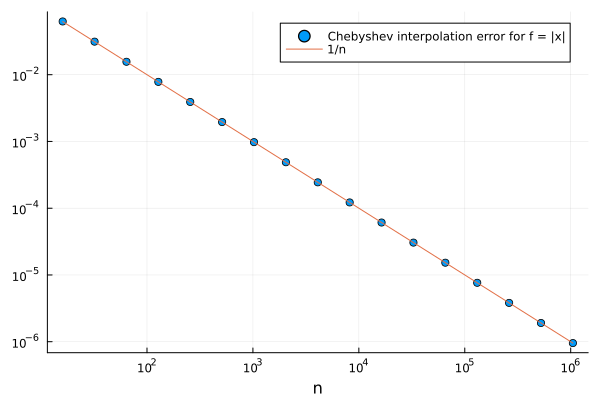

In [386]:
f₁ = x -> abs(x)
xx = range(-1,1;length=1001) # compute the error on this grid
nn = 2 .^(4:20)
S = Chebyshev()
# use ApproxFun to construct and evaluate Chebyshev interpolant
errs = [( pₙ = Fun(f₁,S,n);
        norm(f₁.(xx) - pₙ.(xx),Inf)  ) for n = nn ]
p=scatter(nn,errs;xscale=:log10, yscale=:log10,xlabel="n",
label="Chebyshev interpolation error for f = |x|")
plot!(nn,1 ./nn;label="1/n")

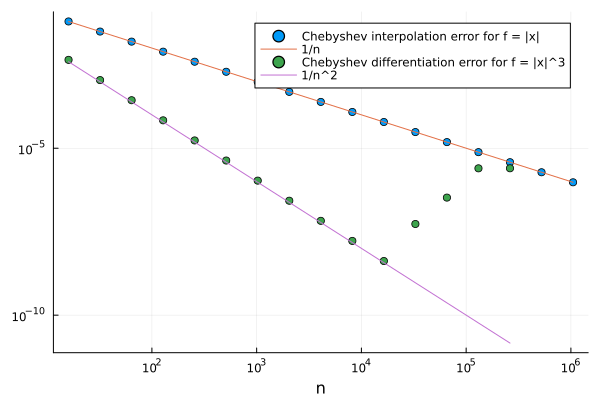

In [387]:
f₂ = x -> abs(x)^3
df₂ = x -> x < 0 ? -3x^2 : 3x^2
nn = 2 .^(4:18)
errs = [( x = cos.(π*(0:n)/n);
          norm(df₂.(x) - chebfft(f₂.(x)),Inf)) for n = nn]
p = scatter!(nn,errs;xscale=:log10, yscale=:log10,xlabel="n",
label="Chebyshev differentiation error for f = |x|^3")
plot!(nn,1 ./nn.^2;label="1/n^2")

The increase of the error for Chebyshev differentiation is caused by a combination of rounding errors on the order of $10^{-15}$ and the $\mathcal{O}(n^2)$ growth in the formulae for Chebyshev differentiation at $x = \pm 1$ (see the function $\texttt{chebfft}$).

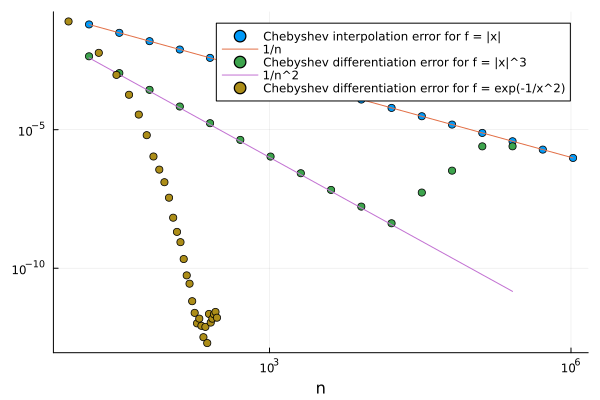

In [388]:
f₃ = x -> exp(-1/x^2)
df₃ = x -> x == 0 ? 0 : 2*exp(-1/x^2)/x^3
nn = 10:10:300
errs = [( x = cos.(π*(0:n)/n);
          norm(df₃.(x) - chebfft(f₃.(x)),Inf)) for n = nn]
p = scatter!(nn,errs;xscale=:log10, yscale=:log10,xlabel="n",
label="Chebyshev differentiation error for f = exp(-1/x^2)")

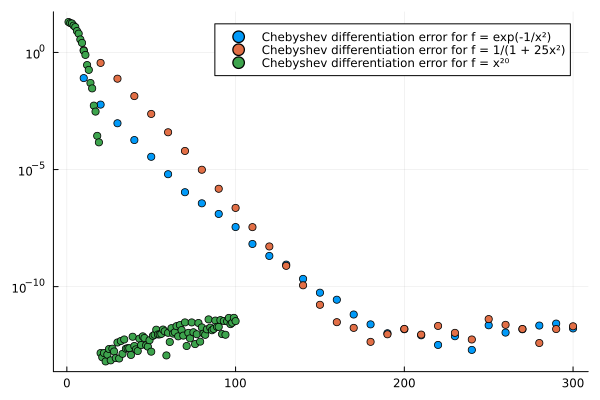

In [389]:
scatter(nn,errs;yscale=:log10,label="Chebyshev differentiation error for f = exp(-1/x²)")
f₄ = x -> 1/(1 + 25x^2)
df₄ = x ->  -50*x/(1 + 25x^2)^2
nn = 10:10:300
errs = [( x = cos.(π*(0:n)/n);
          norm(df₄.(x) - chebfft(f₄.(x)),Inf)) for n = nn]
scatter!(nn,errs;label="Chebyshev differentiation error for f = 1/(1 + 25x²)")
f₅ = x -> x^(20)
df₅ = x ->  20*x^19
nn = 1:100
errs = [( x = cos.(π*(0:n)/n);
          norm(df₅.(x) - chebfft(f₅.(x)),Inf)) for n = nn]
scatter!(nn,errs;label="Chebyshev differentiation error for f = x²⁰")

Note that this a plot with semi-logarithmic axes whereas the previous plot is a log-log set of axes.